# Gradient-based optimisation using _Cheetah_ and _PyTorch_

_Cheetah_ is a differentiable beam dynamics simulation engine, making it ideally suited to gradient-based optimisation, for example for optimisation magnet settings, lattice geometries or even for system identification. _Cheetah_'s tight integration with _PyTorch_ makes this particularly easy as it opens up the use of _PyTorch_'s automatic differentiation capabilities and toolchain.

In this example, we demonstrate how to use _Cheetah_ for **magnet setting optimisation** and how to **add custom normalisation** to that same task.


In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import cheetah

## Simple example (without normalisation)

We start by creating the lattice section and incoming beam.


In [2]:
ares_ea = cheetah.Segment.from_lattice_json("ARESlatticeStage3v1_9.json").subcell(
    "AREASOLA1", "AREABSCR1"
)

In [3]:
incoming_beam = cheetah.ParticleBeam.from_astra(
    "../../benchmark/astra/ACHIP_EA1_2021.1351.001"
)
incoming_beam

ParticleBeam(n=100000, mu_x=tensor(8.2413e-07), mu_xp=tensor(5.9885e-08), mu_y=tensor(-1.7276e-06), mu_yp=tensor(-1.1746e-07), sigma_x=tensor(0.0002), sigma_xp=tensor(3.6794e-06), sigma_y=tensor(0.0002), sigma_yp=tensor(3.6941e-06), sigma_s=tensor(8.0116e-06), sigma_p=tensor(0.0023), energy=tensor(1.0732e+08, dtype=torch.float64))

By default, _Cheetah_ assumes that no part of its simulation requires differentiation and therefore does not track gradients, all parameters are of type `torch.Tensor`. To enable gradient tracking for parameters you would like to optimise over, you need to wrap them in `torch.nn.Parameter`, either when creating your elements and beams, or later on.

In this example, we would like to optimise over the settings of three quadrupoles and two steerers in the experimental area at the _ARES_ accelerator facility at DESY. In this case, we will need to redefine the `k1` and `angle` parameters of the magnets as `torch.nn.Parameter`.

**Note:** You could simply wrap the value of the parameters as the value it already has, e.g.

```python
ares_ea.AREAMQZM1.k1 = nn.Parameter(ares_ea.AREAMQZM1.k1)
```


In [4]:
ares_ea.AREAMQZM1.k1 = nn.Parameter(ares_ea.AREAMQZM1.k1)
ares_ea.AREAMQZM2.k1 = nn.Parameter(ares_ea.AREAMQZM2.k1)
ares_ea.AREAMCVM1.angle = nn.Parameter(ares_ea.AREAMCVM1.angle)
ares_ea.AREAMQZM3.k1 = nn.Parameter(ares_ea.AREAMQZM3.k1)
ares_ea.AREAMCHM1.angle = nn.Parameter(ares_ea.AREAMCHM1.angle)

Next, we define the function that will do the actual optimisation. The goal of our optimisation is to tune the transverse beam parameters `[mu_x, sigma_x, mu_y, sigma_y]` towards some target beam parameters on a diagnostic screen at the end of the considered lattice segment. Hence, we pass the target beam parameters to the `train` function and make use of _PyTorch_'s `torch.nn.function.mse_loss` function. Note that we can easily make use of _PyTorch_'s `Adam` optimiser implementation. As a result the following code looks very similar to a standard _PyTorch_ optimisation loop for the training of neural networks.


In [5]:
def train(num_steps: int, target_beam_parameters: torch.Tensor, lr=0.1) -> dict:
    beam_parameter_history = []
    magnet_setting_history = []
    loss_history = []

    optimizer = torch.optim.Adam(ares_ea.parameters(), lr=lr)

    for _ in range(num_steps):
        optimizer.zero_grad()

        outgoing_beam = ares_ea.track(incoming_beam)

        observed_beam_parameters = torch.stack(
            [
                outgoing_beam.mu_x,
                outgoing_beam.sigma_x,
                outgoing_beam.mu_y,
                outgoing_beam.sigma_y,
            ]
        )
        loss = F.mse_loss(observed_beam_parameters, target_beam_parameters)

        loss.backward()

        # Log magnet settings and beam parameters
        loss_history.append(loss.item())
        beam_parameter_history.append(observed_beam_parameters.detach().numpy())
        magnet_setting_history.append(
            torch.stack(
                [
                    ares_ea.AREAMQZM1.k1,
                    ares_ea.AREAMQZM2.k1,
                    ares_ea.AREAMCVM1.angle,
                    ares_ea.AREAMQZM3.k1,
                    ares_ea.AREAMCHM1.angle,
                ]
            )
            .detach()
            .numpy()
        )
        optimizer.step()

    history = {
        "loss": loss_history,
        "beam_parameters": beam_parameter_history,
        "magnet_settings": magnet_setting_history,
    }
    return history

We now simply run the optimisation function with a target beam that is centred on the origin and focused to be as small as possible.


In [6]:
history = train(num_steps=100, target_beam_parameters=torch.zeros(4))

The returned `history` dictionary allows us to plot the evolution of the optimisation process.


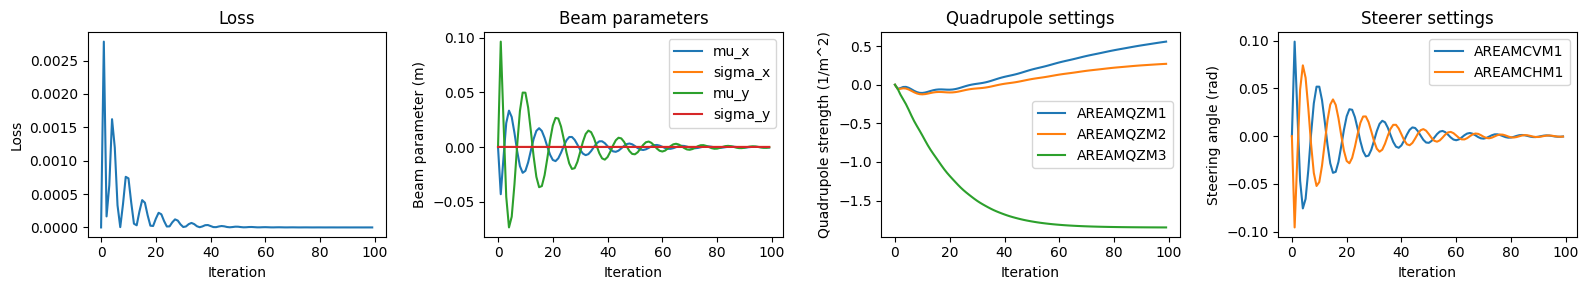

In [7]:
plt.figure(figsize=(16, 3))

plt.subplot(1, 4, 1)
plt.plot(history["loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss")

plt.subplot(1, 4, 2)
plt.plot([record[0] for record in history["beam_parameters"]], label="mu_x")
plt.plot([record[1] for record in history["beam_parameters"]], label="sigma_x")
plt.plot([record[2] for record in history["beam_parameters"]], label="mu_y")
plt.plot([record[3] for record in history["beam_parameters"]], label="sigma_y")
plt.xlabel("Iteration")
plt.ylabel("Beam parameter (m)")
plt.title("Beam parameters")
plt.legend()

plt.subplot(1, 4, 3)
plt.plot([record[0] for record in history["magnet_settings"]], label="AREAMQZM1")
plt.plot([record[1] for record in history["magnet_settings"]], label="AREAMQZM2")
plt.plot([record[3] for record in history["magnet_settings"]], label="AREAMQZM3")
plt.xlabel("Iteration")
plt.ylabel("Quadrupole strength (1/m^2)")
plt.title("Quadrupole settings")
plt.legend()

plt.subplot(1, 4, 4)
plt.plot([record[2] for record in history["magnet_settings"]], label="AREAMCVM1")
plt.plot([record[4] for record in history["magnet_settings"]], label="AREAMCHM1")
plt.xlabel("Iteration")
plt.ylabel("Steering angle (rad)")
plt.title("Steerer settings")
plt.legend()

plt.tight_layout()
plt.show()

Success! 🎉 We can observe that the optimisation converges to a solution that is close to the target beam parameters.

**However**, we can also observe that the quadrupole converges very slowly, indicating that the learning rate is too small, while the steerers keep overshooting the target, indicating that the learning rate is too large. This is a common problem in gradient-based optimisation caused by the very different scales of `k1` and `angle`, and can be solved by **normalising** the parameters under optimisation.

## Normalising parameters in gradient-based optimisation

In the following example we demonstrate how to **normalise** the parameters under optimisation with _Cheetah_. The same principle can also be applied to other custom mechanisms one might like to build around the lattice optimisation process, e.g. to add custom constraints, coupled parameters, etc.

To achieve this, we wrap the lattice section in a `torch.nn.Module` and define a `forward` function that applies the normalisation to the parameters before passing them to the lattice section.

**Note** that this time, simply for the fun of it, we also start with randomly initialised magnet settings.


In [8]:
class NormalizedARESExperimentalArea(nn.Module):
    """
    Wrapper around the AREA experimental area that holds normalised versions of the
    magnet settings as its trainable parameters.
    """

    QUADRUPOLE_LIMIT = 5.0
    STEERER_LIMIT = 6.1782e-3

    def __init__(self) -> None:
        super().__init__()
        self.ares_ea = cheetah.Segment.from_lattice_json(
            "ARESlatticeStage3v1_9.json"
        ).subcell("AREASOLA1", "AREABSCR1")

        # self.normalized_quadrupole_strengths = nn.Parameter(
        #     torch.tensor([10.0, -10.0, 10.0]) / self.QUADRUPOLE_LIMIT
        # )
        # self.normalized_steering_angles = nn.Parameter(
        #     torch.tensor([1e-3, -1e-3]) / self.STEERER_LIMIT
        # )

        self.normalized_quadrupole_strengths = nn.Parameter(torch.randn(3) * 2 - 1)
        self.normalized_steering_angles = nn.Parameter(torch.randn(2) * 2 - 1)

    def forward(self, incoming_beam: cheetah.Beam):
        self.ares_ea.AREAMQZM1.k1 = (
            self.normalized_quadrupole_strengths[0] * self.QUADRUPOLE_LIMIT
        )
        self.ares_ea.AREAMQZM2.k1 = (
            self.normalized_quadrupole_strengths[1] * self.QUADRUPOLE_LIMIT
        )
        self.ares_ea.AREAMCVM1.angle = (
            self.normalized_steering_angles[0] * self.STEERER_LIMIT
        )
        self.ares_ea.AREAMQZM3.k1 = (
            self.normalized_quadrupole_strengths[2] * self.QUADRUPOLE_LIMIT
        )
        self.ares_ea.AREAMCHM1.angle = (
            self.normalized_steering_angles[1] * self.STEERER_LIMIT
        )

        return self.ares_ea.track(incoming_beam)

In [9]:
normalized_ares_ea = NormalizedARESExperimentalArea()

We then redefine the `train` function to use the `torch.nn.Module` instead of the lattice section directly.

**Note** that we also chose to apply normalisation to the beam parameters. This is not strictly necessary, but can help to improve the stability of the optimisation process.


In [10]:
def train_normalized(num_steps: int, target_beam_parameters: torch.Tensor):
    beam_parameter_history = []
    magnet_setting_history = []
    loss_history = []

    optimizer = torch.optim.Adam(normalized_ares_ea.parameters(), lr=1e-1)

    for _ in range(num_steps):
        optimizer.zero_grad()

        outgoing_beam = normalized_ares_ea(incoming_beam)
        observed_beam_parameters = torch.stack(
            [
                outgoing_beam.mu_x,
                outgoing_beam.sigma_x,
                outgoing_beam.mu_y,
                outgoing_beam.sigma_y,
            ]
        )
        loss = F.mse_loss(
            observed_beam_parameters / 2e-3, target_beam_parameters / 2e-3
        )

        loss.backward()

        # Log magnet settings and beam parameters
        loss_history.append(loss.item())
        beam_parameter_history.append(observed_beam_parameters.detach().numpy())
        magnet_setting_history.append(
            torch.stack(
                [
                    normalized_ares_ea.ares_ea.AREAMQZM1.k1,
                    normalized_ares_ea.ares_ea.AREAMQZM2.k1,
                    normalized_ares_ea.ares_ea.AREAMCVM1.angle,
                    normalized_ares_ea.ares_ea.AREAMQZM3.k1,
                    normalized_ares_ea.ares_ea.AREAMCHM1.angle,
                ]
            )
            .detach()
            .numpy()
        )

        optimizer.step()

    history = {
        "loss": loss_history,
        "beam_parameters": beam_parameter_history,
        "magnet_settings": magnet_setting_history,
    }
    return history

Now we run or new `train_normalized` function with the same target beam as before.


In [11]:
history = train_normalized(num_steps=200, target_beam_parameters=torch.zeros(4))

Then we plot the evolution of the optimisation process again.


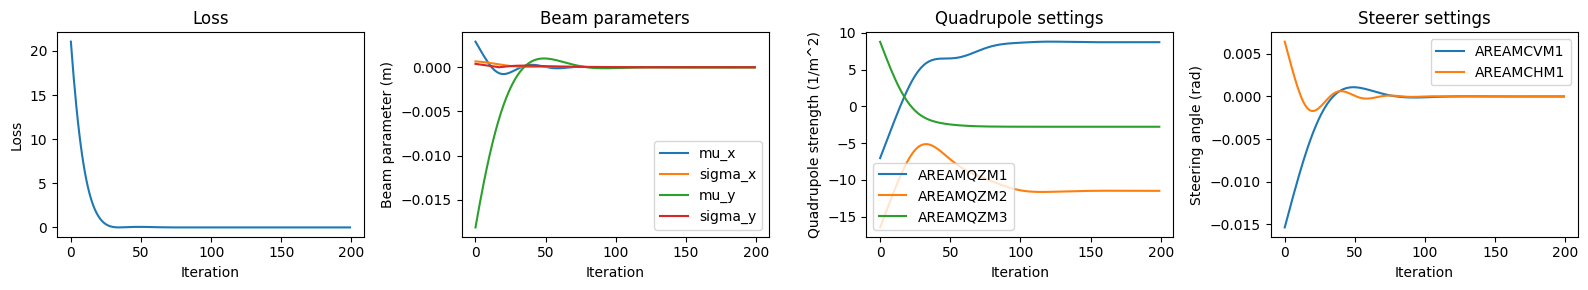

In [12]:
plt.figure(figsize=(16, 3))

plt.subplot(1, 4, 1)
plt.plot(history["loss"])
# plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss")

plt.subplot(1, 4, 2)
plt.plot([record[0] for record in history["beam_parameters"]], label="mu_x")
plt.plot([record[1] for record in history["beam_parameters"]], label="sigma_x")
plt.plot([record[2] for record in history["beam_parameters"]], label="mu_y")
plt.plot([record[3] for record in history["beam_parameters"]], label="sigma_y")
plt.xlabel("Iteration")
plt.ylabel("Beam parameter (m)")
plt.title("Beam parameters")
plt.legend()

plt.subplot(1, 4, 3)
plt.plot([record[0] for record in history["magnet_settings"]], label="AREAMQZM1")
plt.plot([record[1] for record in history["magnet_settings"]], label="AREAMQZM2")
plt.plot([record[3] for record in history["magnet_settings"]], label="AREAMQZM3")
plt.xlabel("Iteration")
plt.ylabel("Quadrupole strength (1/m^2)")
plt.title("Quadrupole settings")
plt.legend()

plt.subplot(1, 4, 4)
plt.plot([record[2] for record in history["magnet_settings"]], label="AREAMCVM1")
plt.plot([record[4] for record in history["magnet_settings"]], label="AREAMCHM1")
plt.xlabel("Iteration")
plt.ylabel("Steering angle (rad)")
plt.title("Steerer settings")
plt.legend()

plt.tight_layout()
plt.show()

As you can see this already looks much better than it did without normalisation.
